In [1]:
import torch
from torch import nn
import torchaudio
import torch.nn.functional as F
from torchvision.transforms import Compose
from torch.utils.data import DataLoader
from time import time

import matplotlib.pyplot as plt

import librosa
import numpy as np

from pathlib import Path

%cd ../io
from load import readAudio, readAnnotations, readMidi, compute_log_filterbank, compute_log_filter_spectrogram
from convert_slakh import MIDI_MAPPING
%cd ..
from preprocess import compute_normalization, create_transform, invert_log_filter_spectrogram
from evaluate import compute_peaks, compute_predictions, f_measure
from models import VisionTransformer, ADTOF_FrameAttention, ADTOF_FrameRNN
%cd notebooks

import IPython

/Users/runarfosse/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis/io


/Users/runarfosse/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis
/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis/notebooks


/Users/runarfosse/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# Declare helper functions

def plot_prediction(model: nn.Module, data: torch.Tensor, label: torch.Tensor, transforms: Compose) -> None:

    # Predict using the model
    with torch.no_grad():
        if transforms:
            data = transforms(data)
        activation = F.sigmoid(model(data))
        prediction = compute_peaks(activation)
        
        predictions = compute_predictions(prediction, label)
        val_f1_micro, val_f1_macro, val_f1_class = f_measure(predictions)
        print("Predictions:", predictions)
        print("Class F1s:", val_f1_class)
        print("Total F1:", val_f1_micro)

    # And plot
    fig, ax = plt.subplots(3)

    ax[0].set_title("Data (400 frames, 84 bins, 1 channel)")
    ax[0].imshow(data.squeeze().T)
    ax[0].set_xlabel("Frames (hop size: 10ms)")
    ax[0].set_ylabel("Frequency bins")
    ax[0].invert_yaxis()

    ax[1].set_title("Target (400 frames, 5 classes)")
    ax[1].imshow(label.squeeze().T.round(), aspect=10, interpolation="nearest")
    ax[1].set_xlabel("Frames (hop size: 10ms)")
    ax[1].set_ylabel("Classes")
    ax[1].set_yticks([0, 1, 2, 3, 4], ("BD", "SD", "TT", "HH", "CY+RD"))
    ax[1].invert_yaxis()

    ax[2].set_title("Prediction (400 frames, 5 classes)")
    ax[2].imshow(prediction.squeeze().T.round(), aspect=10, interpolation="nearest")
    ax[2].set_xlabel("Frames (hop size: 10ms)")
    ax[2].set_ylabel("Classes")
    ax[2].set_yticks([0, 1, 2, 3, 4], ("BD", "SD", "TT", "HH", "CY+RD"))
    ax[2].invert_yaxis()

    fig.tight_layout()
    plt.show()

def visualize(model: nn.Module, transforms: Compose, path: Path, name: str, i: int) -> None:
    # Parse the audio and midi file
    spectrogram = readAudio(path / name / "mix.wav")
    label = readMidi(path / name / "annotation.mid", MIDI_MAPPING, spectrogram.shape[0], 5)

    # "Batch" the data
    data = torch.unsqueeze(spectrogram[i:i+400], dim=0)
    label =  torch.unsqueeze(label[i:i+400], dim=0)

    # And plot it
    plot_prediction(model, data, label, transforms)

In [3]:
# Get the path to the dataset directory
path = Path("../../Master Thesis Dataset").resolve()

In [4]:
# Load a model
model_path = Path("../study/Architecture/Vision Transformer/ADTOF-YT").resolve()
config = torch.load(model_path / "config.pt")
model = VisionTransformer(**config["parameters"])
state_dict = torch.load(model_path / "model.pt", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

# Create a transform
transforms = create_transform(**config["transforms"], channels_last=True)

Predictions: tensor([[3., 1., 1.],
        [3., 1., 0.],
        [8., 9., 6.],
        [0., 0., 0.],
        [1., 0., 0.]])
Class F1s: tensor([0.7500, 0.8571, 0.5161, 0.0000, 1.0000])
Total F1: tensor(0.6250)


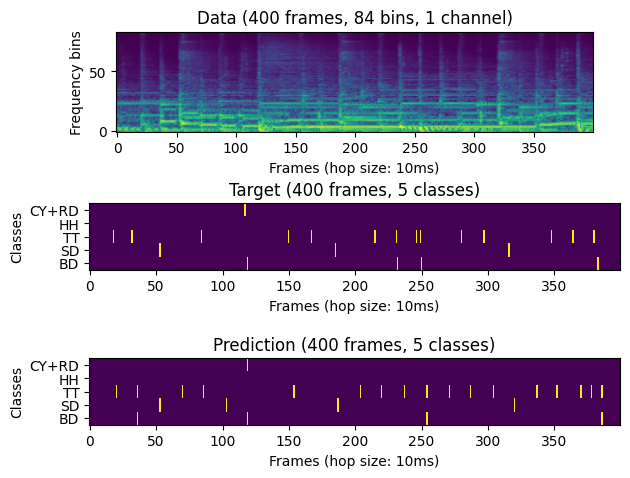

In [ ]:
visualize(model, transforms, path, "Bauklötze", 1000)

Predictions: tensor([[ 8.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [29.,  3.,  2.],
        [ 0.,  0.,  0.]])
Class F1s: tensor([1.0000, 0.0000, 0.0000, 0.9206, 0.0000])
Total F1: tensor(0.9367)


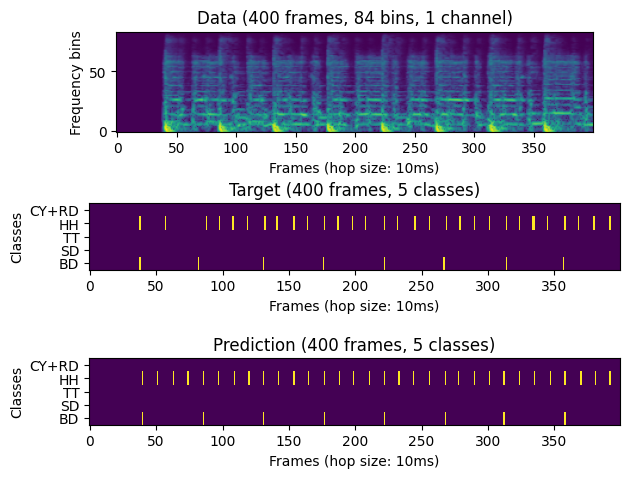

In [6]:
# Predict with a different song
visualize(model, transforms, path, "Life Will Change", 0)

Predictions: tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 3., 1.]])
Class F1s: tensor([0., 0., 0., 0., 0.])
Total F1: tensor(0.)


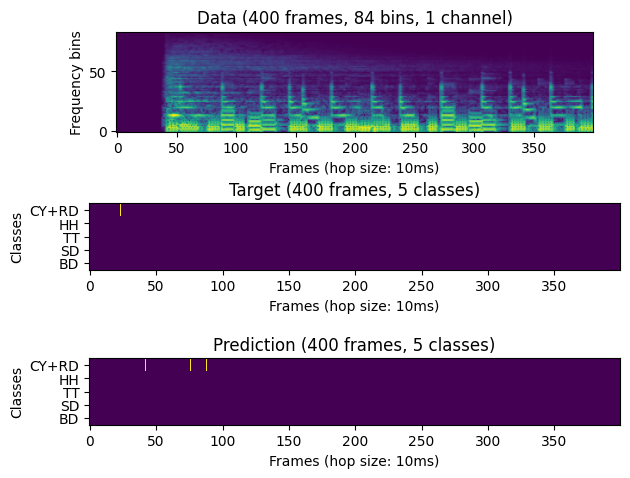

In [7]:
visualize(model, transforms, path, "Escape", 0)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/partitura/io/importmidi.py:245: UserWarning: ignoring MIDI message note_off channel=9 note=42 velocity=64 time=72
  warnings.warn(f"ignoring MIDI message {msg}")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/partitura/io/importmidi.py:245: UserWarning: ignoring MIDI message note_off channel=9 note=42 velocity=64 time=76
  warnings.warn(f"ignoring MIDI message {msg}")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/partitura/io/importmidi.py:245: UserWarning: ignoring MIDI message note_off channel=9 note=42 velocity=64 time=75
  warnings.warn(f"ignoring MIDI message {msg}")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/partitura/io/importmidi.py:245: UserWarning: ignoring MIDI message note_off channel=9 note=42 velocity=64 time=24
  warnings.warn(f"ignoring MIDI message {msg}")
/Library/Frameworks/Python.frame

Predictions: tensor([[10.,  0.,  1.],
        [ 4.,  0.,  0.],
        [ 0.,  0.,  0.],
        [15.,  1., 14.],
        [ 0.,  0.,  0.]])
Class F1s: tensor([0.9524, 1.0000, 0.0000, 0.6667, 0.0000])
Total F1: tensor(0.7838)


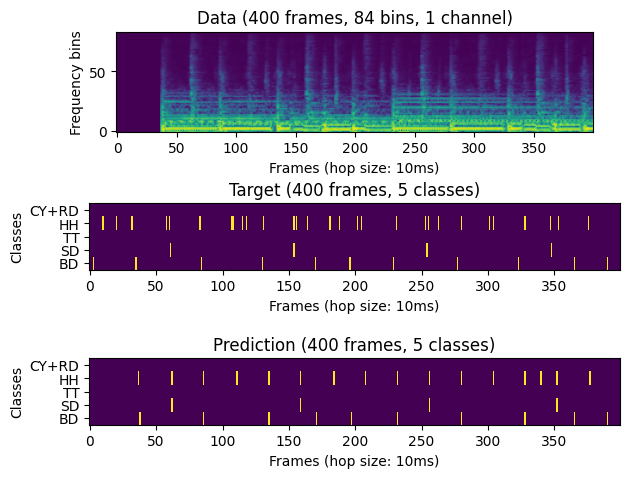

In [8]:
visualize(model, transforms, path, "Phantom", 0)

Predictions: tensor([[ 0.,  1.,  0.],
        [ 0.,  0.,  0.],
        [ 9., 22.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]])
Class F1s: tensor([0.0000, 0.0000, 0.4500, 0.0000, 0.0000])
Total F1: tensor(0.4390)


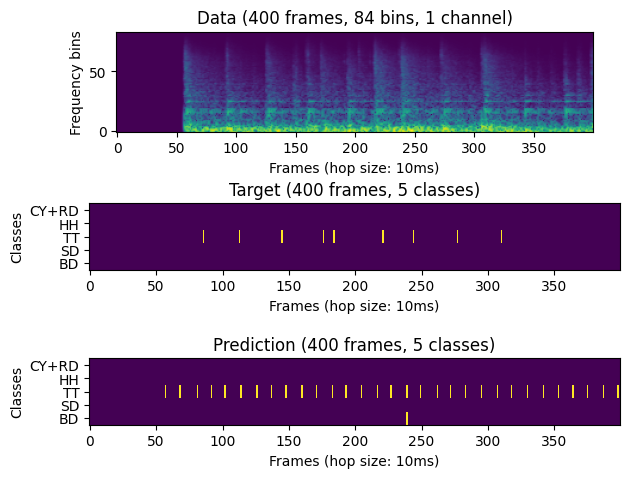

In [9]:
# Predict with a different song
visualize(model, transforms, path, "Splinter Wolf", 0)

Predictions: tensor([[ 3.,  6.,  3.],
        [ 4.,  0.,  1.],
        [ 0.,  0.,  0.],
        [11.,  6., 10.],
        [ 0.,  0.,  0.]])
Class F1s: tensor([0.4000, 0.8889, 0.0000, 0.5789, 0.0000])
Total F1: tensor(0.5806)


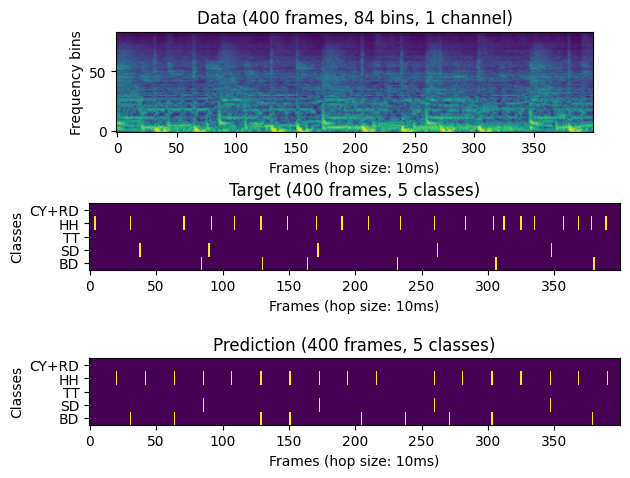

In [10]:
visualize(model, transforms, path, "A1Gう", 1500)

Predictions: tensor([[5., 3., 5.],
        [3., 1., 1.],
        [0., 0., 0.],
        [5., 7., 9.],
        [0., 1., 0.]])
Class F1s: tensor([0.5556, 0.7500, 0.0000, 0.3846, 0.0000])
Total F1: tensor(0.4906)


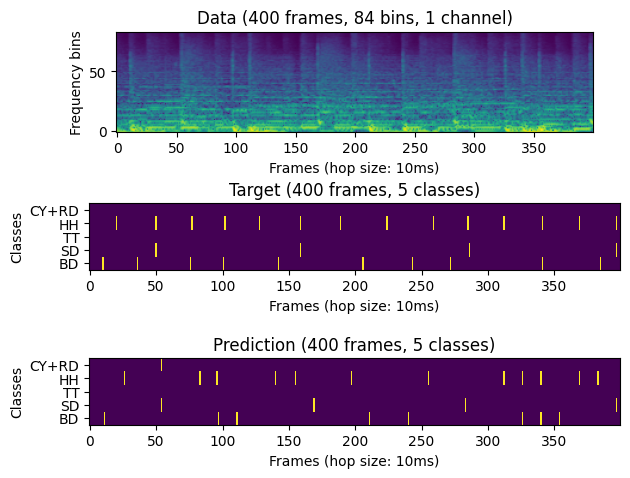

In [11]:
visualize(model, transforms, path, "Barricades", 2000)

Predictions: tensor([[ 5.,  0.,  0.],
        [ 1.,  1.,  0.],
        [ 0.,  0.,  0.],
        [10.,  5.,  1.],
        [ 1.,  0.,  0.]])
Class F1s: tensor([1.0000, 0.6667, 0.0000, 0.7692, 1.0000])
Total F1: tensor(0.8293)


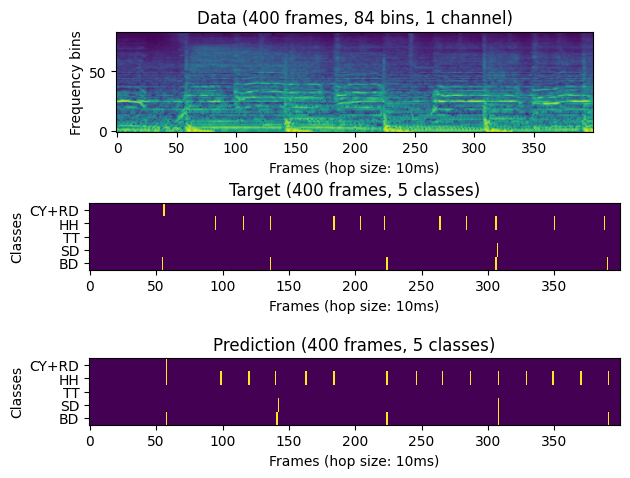

In [12]:
visualize(model, transforms, path, "Barricades (MOVIEver.)", 10000)

Predictions: tensor([[8., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 0., 0.]])
Class F1s: tensor([0.8889, 0.0000, 0.0000, 0.0000, 0.0000])
Total F1: tensor(0.8421)


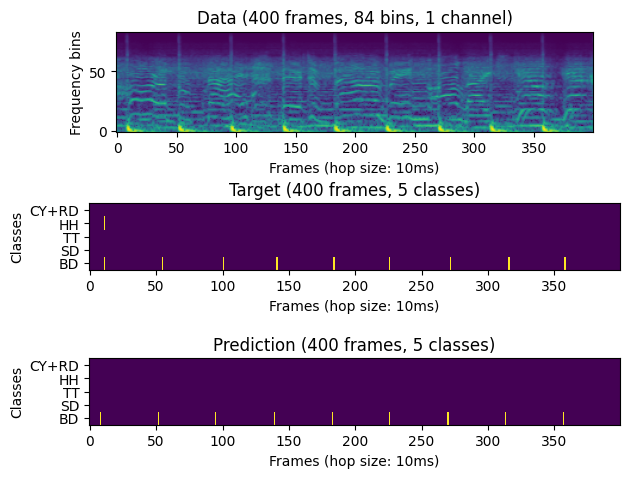

In [13]:
visualize(model, transforms, path, "DOA", 3000)

Predictions: tensor([[ 3.,  2.,  4.],
        [ 4.,  1.,  1.],
        [17.,  2.,  6.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  0.]])
Class F1s: tensor([0.5000, 0.8000, 0.8095, 0.0000, 0.6667])
Total F1: tensor(0.7463)


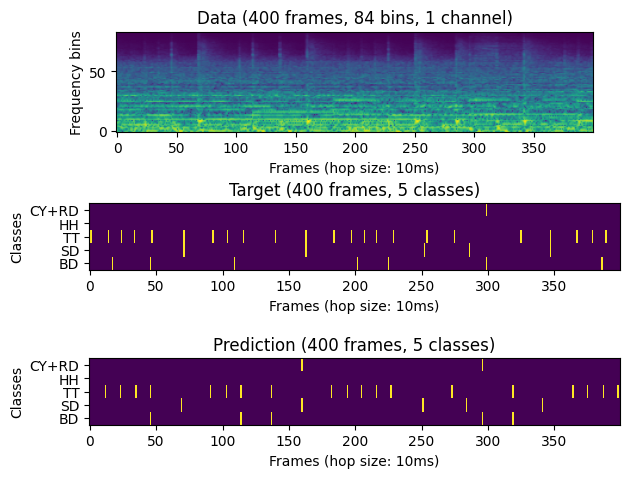

In [14]:
visualize(model, transforms, path, "Red Swan", 1600)

Predictions: tensor([[ 1.,  2.,  4.],
        [ 2.,  1.,  1.],
        [ 3.,  0., 11.],
        [ 0.,  1.,  0.],
        [ 1.,  1.,  0.]])
Class F1s: tensor([0.2500, 0.6667, 0.3529, 0.0000, 0.6667])
Total F1: tensor(0.4000)


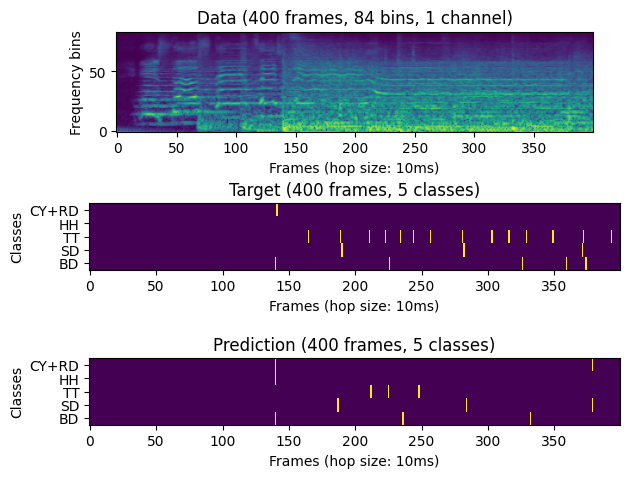

In [15]:
visualize(model, transforms, path, "ətˈæk 0N tάɪtn", 14500)

Predictions: tensor([[ 1.,  6.,  5.],
        [ 0.,  0.,  3.],
        [ 0.,  0.,  0.],
        [ 6.,  6., 15.],
        [ 0., 10.,  0.]])
Class F1s: tensor([0.1538, 0.0000, 0.0000, 0.3636, 0.0000])
Total F1: tensor(0.2373)


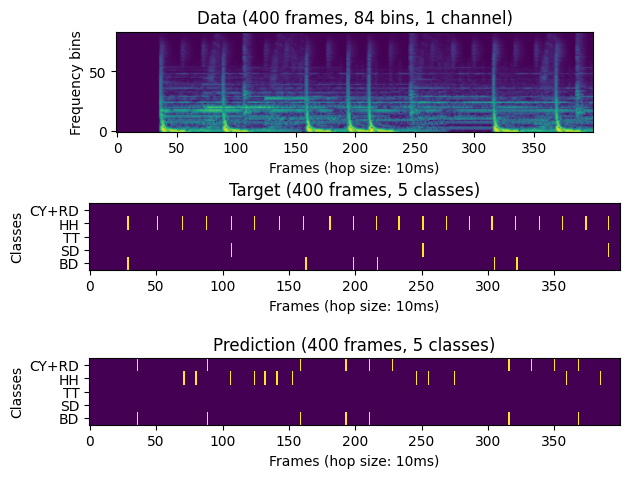

In [26]:
visualize(model, transforms, path, "The Dogs", 0)

Predictions: tensor([[ 6.,  2.,  4.],
        [ 2.,  1.,  1.],
        [ 0.,  0.,  0.],
        [23., 13.,  0.],
        [ 0.,  0.,  0.]])
Class F1s: tensor([0.6667, 0.6667, 0.0000, 0.7797, 0.0000])
Total F1: tensor(0.7470)


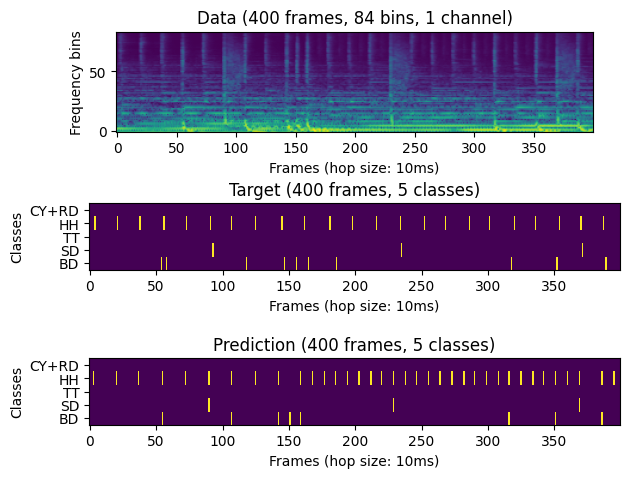

In [22]:
visualize(model, transforms, path, "cóunter・attàck-mˈænkάɪnd", 2400)